When executing eagerly (outside of jit), JAX code works with Python control flow and logical operators just like Numpy code. Using control flow and logical operators with jit is more complicated.

In a nutshell, Python control flow and logical operators are evaluated at JIT compile time, such that the compiled function represents a single path through the control flow graph (logical operators affect the path via short-circuiting). If the path depends on the values of the inputs, the function (by default) cannot be JIT compiled. The path may depend on the shape or dtype of the inputs, and the function is re-compiled every time it is called on an input with a new shape or dtype.

In [1]:
from jax import grad, jit
import jax.numpy as jnp

For example, this works:

In [2]:
@jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x

print(f(3))

24


So does this:

In [3]:
@jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y

print(g(jnp.array([1., 2., 3.])))

6.0


But this doesn’t, at least by default:

In [4]:
@jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
f(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /tmp/ipython-input-4-3402096563.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

Neither does this:

In [5]:
@jit
def g(x):
  return (x > 0) and (x < 3)

# This will fail!
g(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function g at /tmp/ipython-input-5-543860509.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

**What gives!?**

When we jit-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can cache and reuse the compiled code. That way we don’t have to re-compile on each function evaluation.

For example, if we evaluate an @jit function on the array jnp.array([1., 2., 3.], jnp.float32), we might want to compile code that we can reuse to evaluate the function on jnp.array([4., 5., 6.], jnp.float32) to save on compile time.

To get a view of your Python code that is valid for many different argument values, JAX traces it with the ShapedArray abstraction as input, where each abstract value represents the set of all array values with a fixed shape and dtype. For example, if we trace using the abstract value ShapedArray((3,), jnp.float32), we get a view of the function that can be reused for any concrete value in the corresponding set of arrays. That means we can save on compile time.

But there’s a tradeoff here: if we trace a Python function on a ShapedArray((), jnp.float32) that isn’t committed to a specific concrete value, when we hit a line like if x < 3, the expression x < 3 evaluates to an abstract ShapedArray((), jnp.bool_) that represents the set {True, False}. When Python attempts to coerce that to a concrete True or False, we get an error: we don’t know which branch to take, and can’t continue tracing! The tradeoff is that with higher levels of abstraction we gain a more general view of the Python code (and thus save on re-compilations), but we require more constraints on the Python code to complete the trace.

The good news is that you can control this tradeoff yourself. By having jit trace on more refined abstract values, you can relax the traceability constraints. For example, using the static_argnames (or static_argnums) argument to jit, we can specify to trace on concrete values of some arguments. Here’s that example function again:

In [6]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnames='x')

print(f(2.))

12.0


Here’s another example, this time involving a loop:

In [7]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jit(f, static_argnames='n')

f(jnp.array([2., 3., 4.]), 2)

Array(5., dtype=float32)

In effect, the loop gets statically unrolled. JAX can also trace at higher levels of abstraction, like Unshaped, but that’s not currently the default for any transformation

️⚠️ **functions with argument-value dependent shapes**

These control-flow issues also come up in a more subtle way: numerical functions we want to jit can’t specialize the shapes of internal arrays on argument values (specializing on argument shapes is ok). As a trivial example, let’s make a function whose output happens to depend on the input variable length.

In [8]:
def example_fun(length, val):
  return jnp.ones((length,)) * val
# un-jit'd works fine
print(example_fun(5, 4))

[4. 4. 4. 4. 4.]


In [9]:
bad_example_jit = jit(example_fun)
# this will fail:
bad_example_jit(10, 4)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function example_fun at /tmp/ipython-input-8-1210496444.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument length.

In [10]:
# static_argnames tells JAX to recompile on changes at these argument positions:
good_example_jit = jit(example_fun, static_argnames='length')
# first compile
print(good_example_jit(10, 4))
# recompiles
print(good_example_jit(5, 4))

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[4. 4. 4. 4. 4.]


static_argnames can be handy if length in our example rarely changes, but it would be disastrous if it changed a lot!

Lastly, if your function has global side-effects, JAX’s tracer can cause weird things to happen. A common gotcha is trying to print arrays inside jit’d functions:

In [11]:
@jit
def f(x):
  print(x)
  y = 2 * x
  print(y)
  return y
f(2)

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>


Array(4, dtype=int32, weak_type=True)

# Structured control flow primitives

There are more options for control flow in JAX. Say you want to avoid re-compilations but still want to use control flow that’s traceable, and that avoids un-rolling large loops. Then you can use these 4 structured control flow primitives:

1. lax.cond differentiable

2. lax.while_loop fwd-mode-differentiable

3. lax.fori_loop fwd-mode-differentiable in general; fwd and rev-mode differentiable if endpoints are static.

4. lax.scan differentiable

## cond

python equivalent:

In [12]:
def cond(pred, true_fun, false_fun, operand):
  if pred:
    return true_fun(operand)
  else:
    return false_fun(operand)

In [13]:
from jax import lax

operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, operand)
# --> array([1.], dtype=float32)
lax.cond(False, lambda x: x+1, lambda x: x-1, operand)
# --> array([-1.], dtype=float32)

Array([-1.], dtype=float32)

jax.lax provides two other functions that allow branching on dynamic predicates:

1. lax.select is like a batched version of lax.cond, with the choices expressed as pre-computed arrays rather than as functions.

2. lax.switch is like lax.cond, but allows switching between any number of callable choices.

In addition, jax.numpy provides several numpy-style interfaces to these functions:

1. jnp.where with three arguments is the numpy-style wrapper of lax.select.

2. jnp.piecewise is a numpy-style wrapper of lax.switch, but switches on a list of boolean conditions rather than a single scalar index.

3. jnp.select has an API similar to jnp.piecewise, but the choices are given as pre-computed arrays rather than as functions. It is implemented in terms of multiple calls to lax.select.

## while-loop

python equivalent:

In [14]:
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

In [15]:
init_val = 0
cond_fun = lambda x: x < 10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)
# --> array(10, dtype=int32)

Array(10, dtype=int32, weak_type=True)

## fori_loop

python equivalent:

In [16]:
def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val

In [17]:
init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
lax.fori_loop(start, stop, body_fun, init_val)
# --> array(45, dtype=int32)

Array(45, dtype=int32, weak_type=True)

# Summary

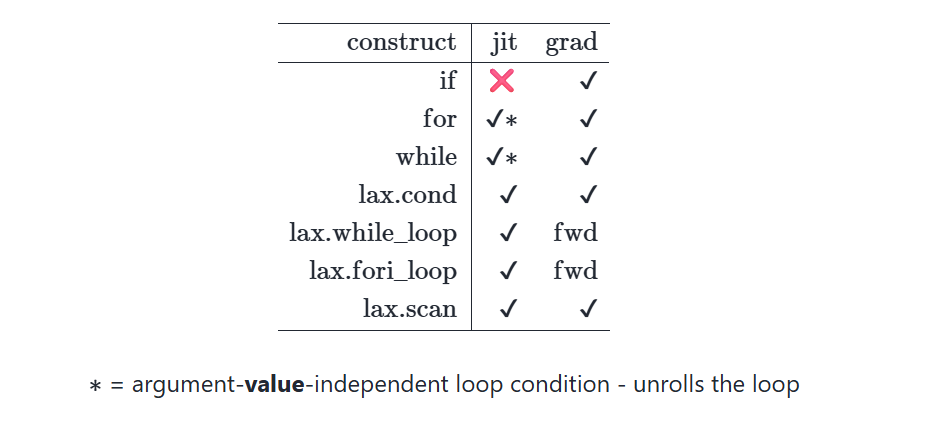

# Logical operators

jax.numpy provides logical_and, logical_or, and logical_not, which operate element-wise on arrays and can be evaluated under jit without recompiling. Like their Numpy counterparts, the binary operators do not short circuit. Bitwise operators (&, |, ~) can also be used with jit.

For example, consider a function that checks if its input is a positive even integer. The pure Python and JAX versions give the same answer when the input is scalar.

In [18]:
def python_check_positive_even(x):
  is_even = x % 2 == 0
  # `and` short-circults, so when `is_even` is `False`, `x > 0` is not evaluated.
  return is_even and (x > 0)

@jit
def jax_check_positive_even(x):
  is_even = x % 2 == 0
  # `logical_and` does not short circuit, so `x > 0` is always evaluated.
  return jnp.logical_and(is_even, x > 0)

print(python_check_positive_even(24))
print(jax_check_positive_even(24))

True
True


When the JAX version with logical_and is applied to an array, it returns elementwise values.

In [19]:
x = jnp.array([-1, 2, 5])
print(jax_check_positive_even(x))

[False  True False]


[False  True False]
Python logical operators error when applied to JAX arrays of more than one element, even without jit. This replicates NumPy’s behavior.

In [20]:
print(python_check_positive_even(x))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Python control flow + autodiff

Remember that the above constraints on control flow and logical operators are relevant only with jit. If you just want to apply grad to your python functions, without jit, you can use regular Python control-flow constructs with no problems, as if you were using Autograd (or Pytorch or TF Eager).

In [21]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

12.0
-4.0
